# Fit the initial and final states

We need the refl1d model to feed to the RL. Below are examples of how to obtain them.

In [22]:
import os
import numpy

from refl1d.names import *
from bumps.fitters import fit

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# Choose data directories

In [34]:
# Data directories
steady_state_data_dir = os.path.expanduser('~/Downloads')
kinetics_dir = os.path.expanduser('~/Downloads/kinetics')
output_dir = '../data'

In [93]:
def create_model(reduced_file, add_surface_layer=False):
    # .mft files have a header we need to skip
    skiprows = 24 if reduced_file.endswith('.mft') else 0

    # Maximum Q-value ##############################################################
    q_min = 0.0041
    q_max = 1.0

    Q, R, dR, dQ = numpy.loadtxt(reduced_file, skiprows=skiprows).T
    i_min = min([i for i in range(len(Q)) if Q[i]>q_min])
    i_max = max([i for i in range(len(Q)) if Q[i]<q_max])+1

    # SNS data is FWHM
    dQ_std = dQ/2.35
    probe = QProbe(Q[i_min:i_max], dQ_std[i_min:i_max], data=(R[i_min:i_max], dR[i_min:i_max]))

    # Materials ####################################################################
    air = SLD(name='air', rho=0.0, irho=0.0)
    Si = SLD(name='Si', rho=1.971, irho=0.0)
    poly = SLD(name='poly', rho=0.6962, irho=0.0)
    enrich = SLD(name='enrich', rho=-0.006987, irho=0.0)
    SiOx = SLD(name='SiOx', rho=3.3, irho=0.0)
    surface = SLD(name='surface', rho=1.9, irho=0)


    # Film definition ##############################################################
    if add_surface_layer:
        sample = (  Si(0, 2.739) | SiOx(19.4, 3.21) | enrich(8.0, 3.0) | poly(398, 15.4) | surface(26, 7) | air )
        sample['surface'].thickness.range(10.0, 50.0)
        sample['surface'].material.rho.range(0.0, 3.0)
        sample['surface'].interface.range(1.0, 20.0)
    else:
        sample = (  Si(0, 2.739) | SiOx(19.4, 3.21) | enrich(8.0, 3.0) | poly(342.6, 11.4) | air )

    sample['poly'].thickness.range(200.0, 500.0)
    sample['poly'].material.rho.range(0.0, 3.3)
    sample['poly'].interface.range(1.0, 20.0)
    sample['enrich'].thickness.range(5.0, 15.0)
    sample['enrich'].material.rho.range(-1.0, 6.0)
    sample['enrich'].interface.range(1.0, 4.0)
    #sample['SiOx'].thickness.range(5.0, 35.0)
    #sample['SiOx'].material.rho.range(3.0, 4.0)
    #sample['SiOx'].interface.range(1.0, 4.0)

    probe.intensity=Parameter(value=0.86,name='normalization')
    #probe.intensity=Parameter(value=0.818,name='normalization')
    #probe.intensity.range(0.8, 1)
    probe.background=Parameter(value=0.0,name='background')
    #sample['Si'].interface.range(1.0, 5.0)

    ################################################################################

    expt = Experiment(probe=probe, sample=sample)
    problem = FitProblem(expt)
    return Q, R, dR, problem, expt


In [94]:
from refl1d import errors
from scipy.stats.mstats import mquantiles

def get_sld_contour(problem, results, cl=60, npoints=200, trim=1000, portion=1, index=1, align='auto'):
    points, _logp = results.state.sample(portion=portion)
    
    points = points[-trim:-1]
    
    original = problem.getp()
    
    _profiles, slabs, Q, residuals = errors.calc_errors(problem, points)

    problem.setp(original)
    
    profiles = errors.align_profiles(_profiles, slabs, align)

    # Group 1 is rho
    # Group 2 is irho
    # Group 3 is rhoM
    for model, group in profiles.items():
        ## Find limits of all profiles
        z = np.hstack([line[0] for line in group])
        zp = np.linspace(np.min(z), np.max(z), npoints)

        # Columns are z, best, low, high
        data, cols = errors._build_profile_matrix(group, index, zp, [cl])

        return data

In [26]:
def plot_fit(experiment, results, q, r, dr, reverse=False):
    qq, r_fit = experiment.reflectivity()
    z_fit, sld_fit, _ = experiment.smooth_profile()

    fig, ax = plt.subplots(1, 2, dpi=350, figsize=(10,4))
    ax = plt.subplot(1, 2, 1)
    plt.errorbar(q, r, yerr=dr, markersize=7, marker='.', linestyle='-', color='orange', label='data', zorder=-1)
    plt.plot(qq, r_fit, markersize=4, marker='', linewidth=2, linestyle='-', color='steelblue', label='Refined')

    plt.legend(frameon=False)
    plt.xlabel('q ($1/\AA$)')
    plt.ylabel('R(q)')
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = plt.subplot(1, 2, 2)

    z, best, low, high = get_sld_contour(problem, results, cl=90, align=0, trim=300, portion=1)
    _z = z[-1]-z if reverse else z
    
    plt.plot(_z, best, markersize=4, marker='', linewidth=2, color='steelblue', linestyle='-', label='Refined')
    plt.fill_between(_z, low, high, alpha=0.2, color=plt.gca().lines[-1].get_color())


    plt.legend(frameon=False)
    plt.xlabel('z ($\AA$)', fontsize=14)
    plt.ylabel('SLD ($10^{-6}/\AA^2$)', fontsize=14)
    plt.show()

# Fit the initial state

In [72]:
data_file = os.path.join(steady_state_data_dir, 'initial_state.mft')
q, r, dr, problem, experiment = create_model(data_file)

results = fit(problem, method='dream', samples=5500, burn=1500, pop=10, verbose=True)

# Save the refined model
experiment.save(os.path.join(output_dir, 'initial_state'))

# steps: 50, # draws: 5500
step 1 cost 284.945(72)
                               intensity .........|          1 in (0.8,1)
                            Si interface ....|.....      2.739 in (1,5)
                          SiOx interface .......|..       3.21 in (1,4)
                                SiOx rho ..|.......        3.3 in (3,4)
                          SiOx thickness ....|.....       19.4 in (5,35)
                        enrich interface ......|...          3 in (1,4)
                              enrich rho .|........ -0.00698987 in (-1,6)
                        enrich thickness ...|......          8 in (5,15)
                          poly interface .....|....       11.4 in (1,20)
                                poly rho ..|.......   0.696203 in (0,3.3)
                          poly thickness ......|...      342.6 in (10,500)
step 61 cost 4.595(72)
step 122 cost 2.738(72)
step 183 cost 2.691(72)
step 244 cost 2.612(72)
step 305 cost 2.580(72)
step 366 cost 2.561(72)
st

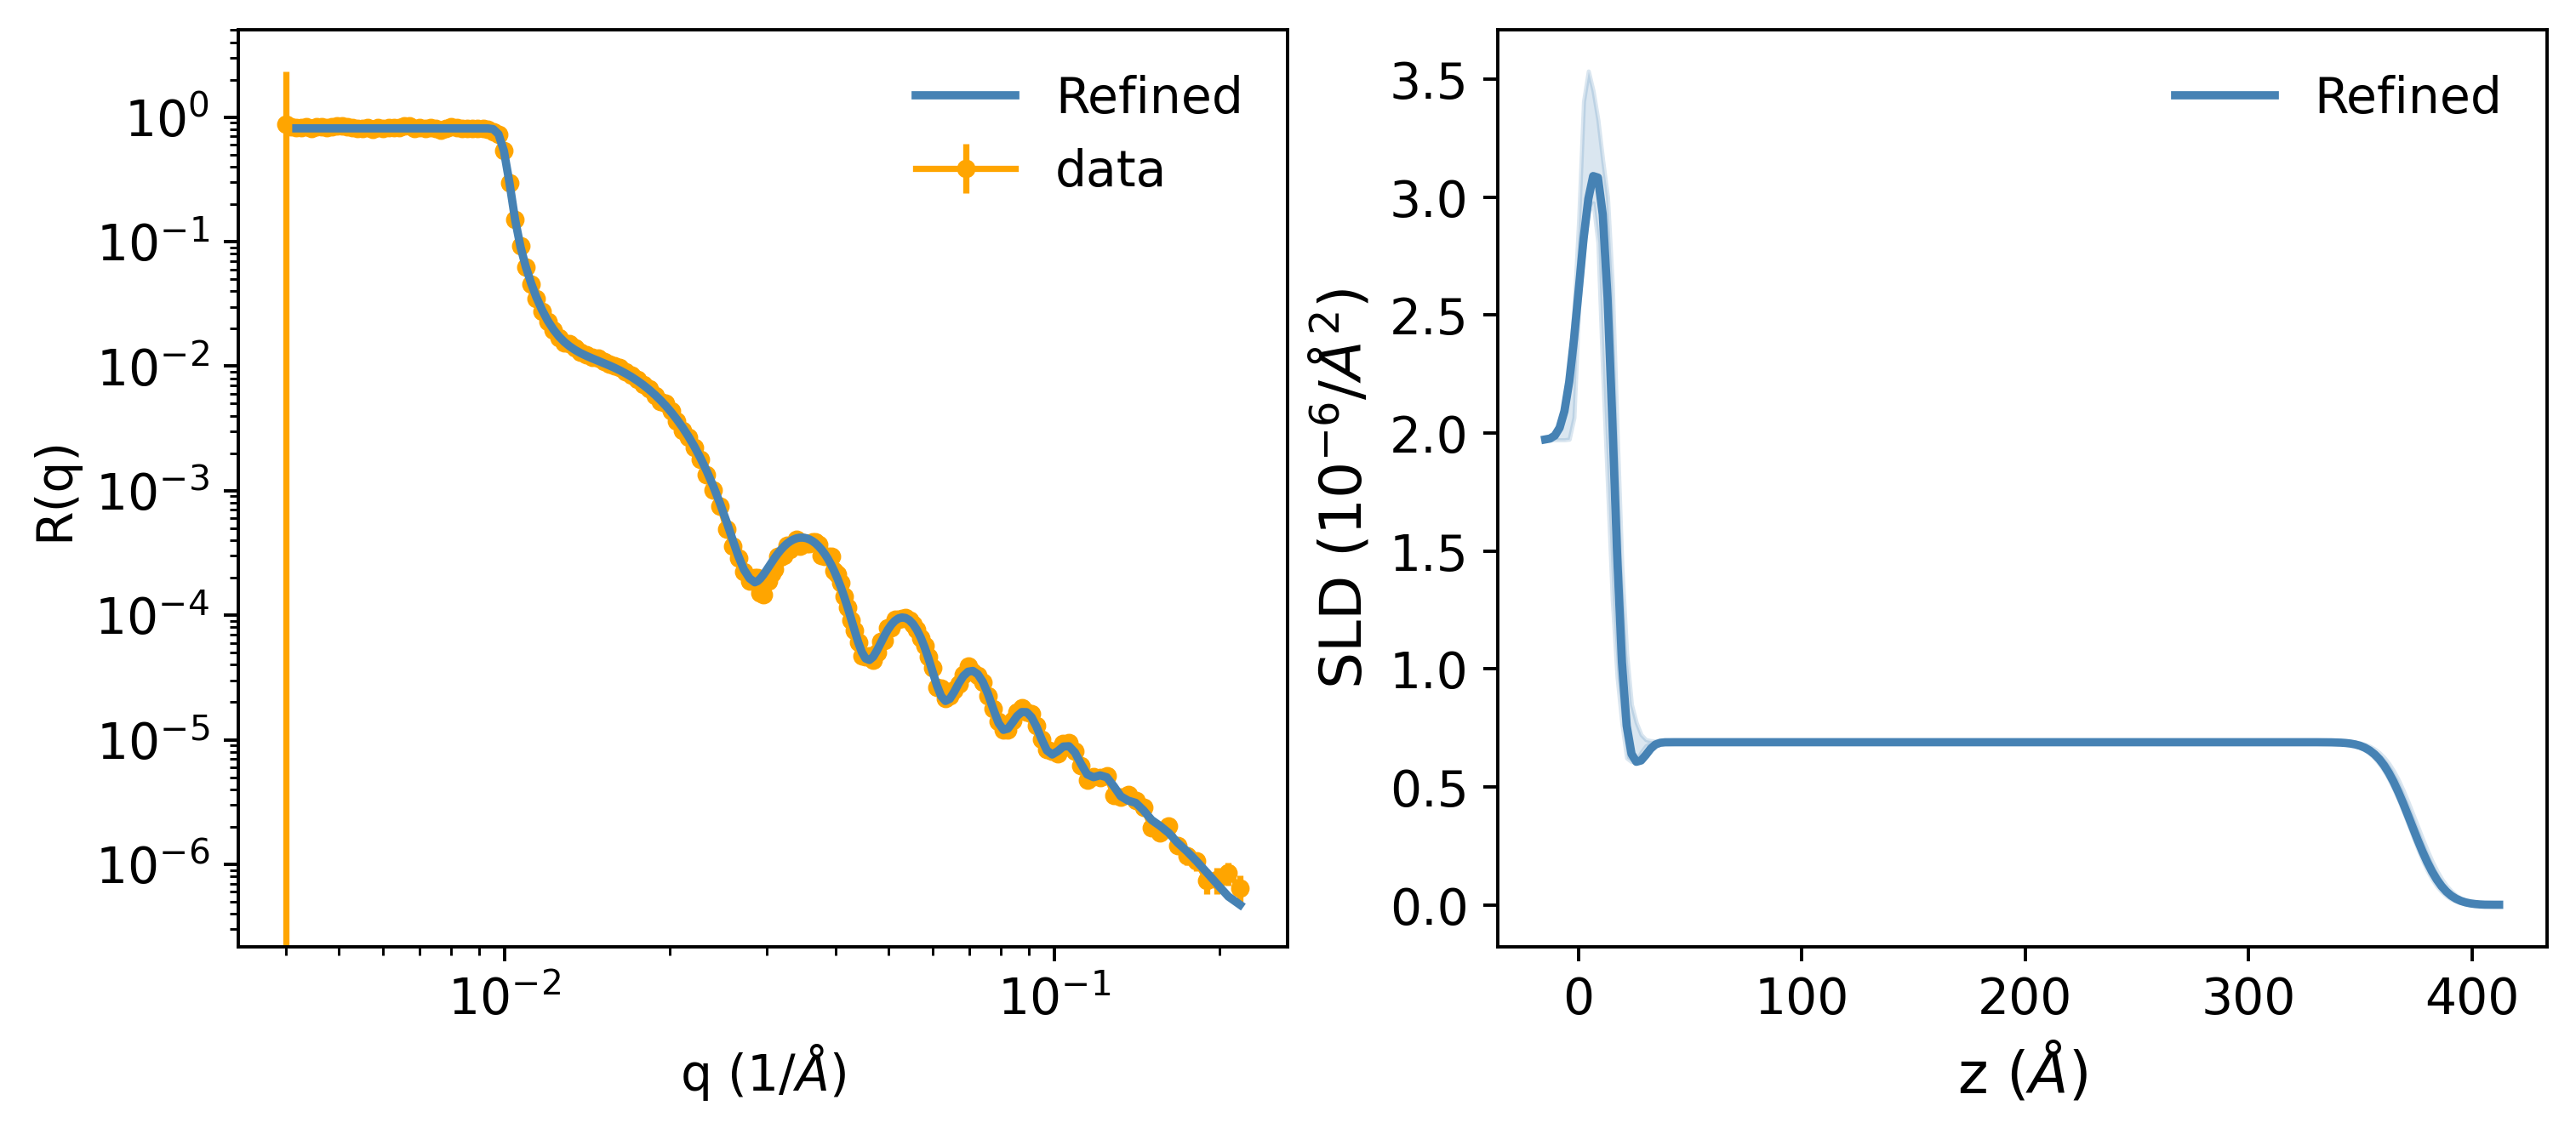

In [73]:
plot_fit(experiment, results, q, r, dr)

# Fit final state

In [95]:
data_file = os.path.join(steady_state_data_dir, 'final_state.mft')
q, r, dr, problem, experiment = create_model(data_file, add_surface_layer=True)

results = fit(problem, method='dream', samples=25500, burn=25000, pop=20, verbose=True)

# Save the refined model
experiment.save(os.path.join(output_dir, 'final_state'))
                


# steps: 142, # draws: 25560
step 1 cost 2622.507(60)
                        enrich interface ......|...          3 in (1,4)
                              enrich rho .|........ -0.00699379 in (-1,6)
                        enrich thickness ..|.......          8 in (5,15)
                          poly interface .......|..       15.4 in (1,20)
                                poly rho ..|.......   0.696197 in (0,3.3)
                          poly thickness ......|...        398 in (200,500)
                       surface interface ...|......    6.99998 in (1,20)
                             surface rho ......|...        1.9 in (0,3)
                       surface thickness ...|......         26 in (10,50)
step 36 cost 2418.838(60)
step 71 cost 85.136(60)
step 106 cost 27.103(60)
step 141 cost 21.139(60)
step 176 cost 20.159(60)
step 211 cost 19.674(60)
step 246 cost 19.265(60)
step 281 cost 18.784(60)
step 316 cost 18.784(60)
step 351 cost 18.763(60)
step 386 cost 18.763(60)
step 421 c

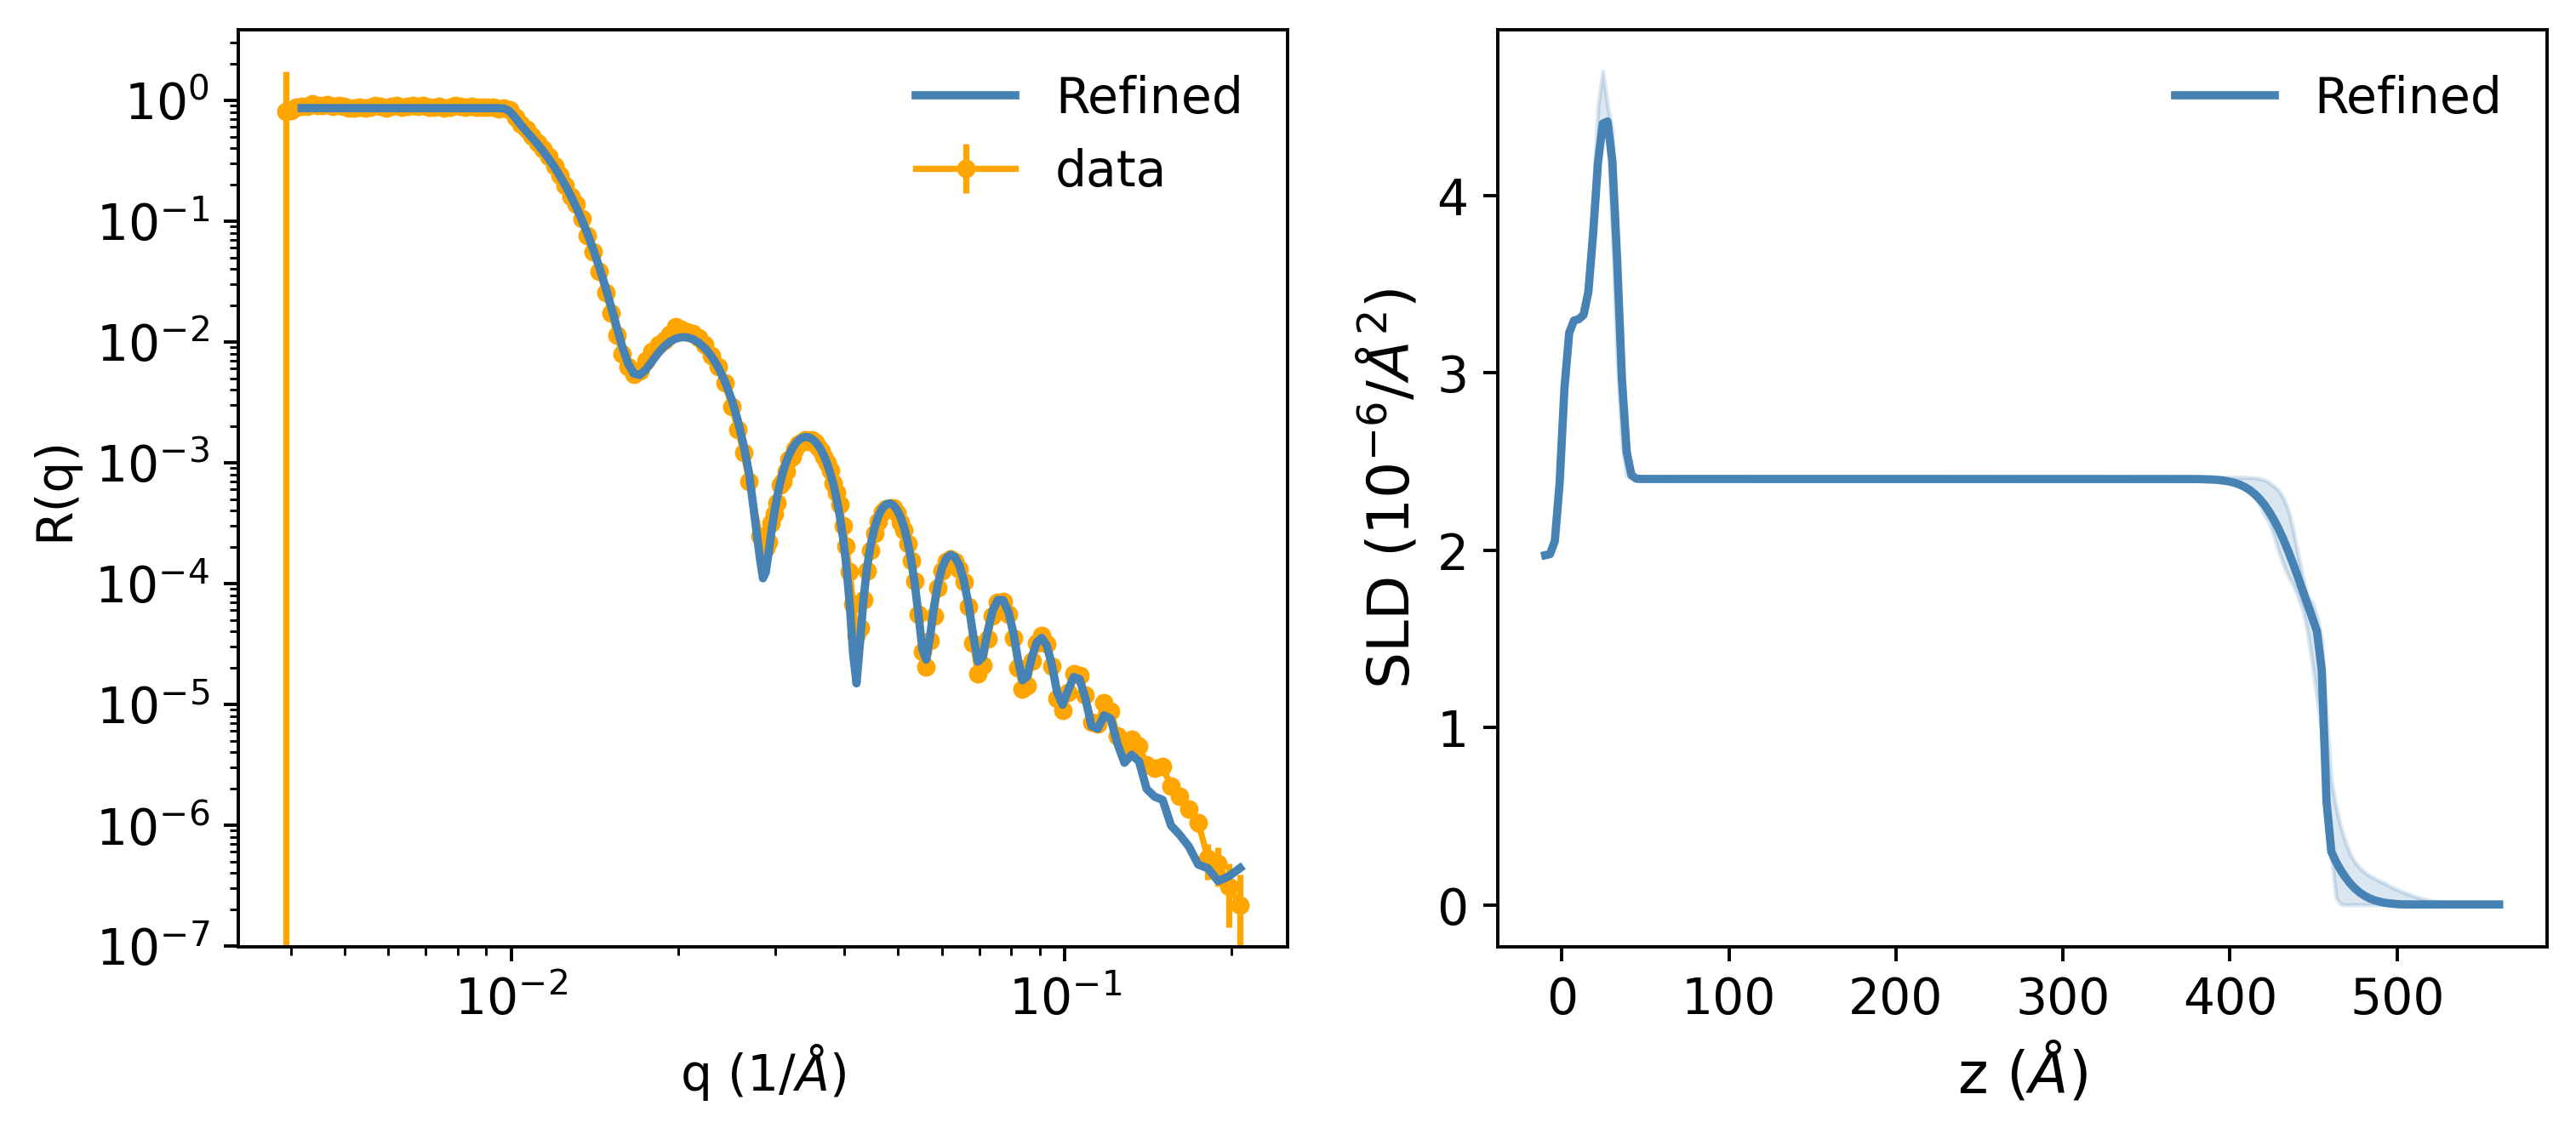

In [96]:
plot_fit(experiment, results, q, r, dr)